# LAB 2 &ndash; Visual cryptography, pt. 1

In order to make sense of some of the things we mentioned in class, it is useful to see them in action on image files; for we, as humans, are quite good at visually detecting patterns in an array of pixels.

First thing to do: double-click on this text cell to write your <b style="color: red">MATANGA Allan, ZAJAC Clément</b>.

## 1) First attempt

Here is a picture of Bletchley Park, where modern computing was born as Alan Turing and thousands of cryptananalysists worked on the breaking of the German codes during WWII:

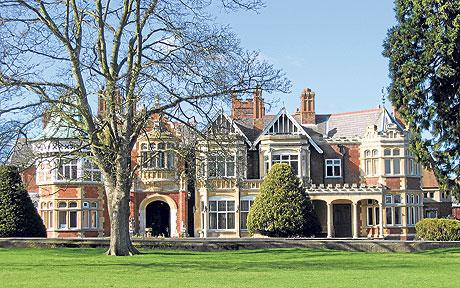

In [7]:
from Image import *              # custom library (you may need to pip install matplotlib)

m1 = LoadImage("bletchley.tiff")
m1                               # displays it

Internally, it's just a $288 \times 460$ matrix of pixels, each of which is colored according to a RGB triple of integers between 0 and 255:

In [8]:
m1.data

array([[[126, 157, 186],
        [200, 231, 255],
        [169, 199, 233],
        ...,
        [ 33,  49,  20],
        [ 83,  98,  59],
        [ 72,  88,  43]],

       [[ 94, 125, 154],
        [145, 176, 207],
        [143, 173, 207],
        ...,
        [128, 143, 114],
        [ 19,  34,   0],
        [140, 155, 112]],

       [[ 28,  59,  90],
        [ 18,  49,  80],
        [ 25,  55,  89],
        ...,
        [ 47,  62,  33],
        [ 70,  84,  48],
        [202, 217, 176]],

       ...,

       [[163, 195,  94],
        [164, 196,  95],
        [170, 202, 101],
        ...,
        [162, 197,  97],
        [162, 197,  97],
        [156, 191,  91]],

       [[168, 200,  99],
        [166, 198,  97],
        [173, 205, 104],
        ...,
        [152, 187,  87],
        [154, 189,  89],
        [152, 187,  87]],

       [[154, 186,  85],
        [152, 184,  83],
        [164, 196,  95],
        ...,
        [161, 196,  96],
        [162, 197,  97],
        [159, 194,  94]]

Recall that the goal of encryption would be to reversibly make it look like a random image of the same size just like this one:

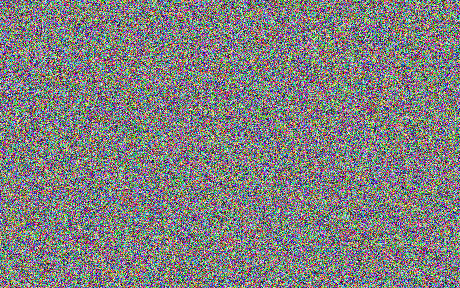

(288, 460) Image

In [13]:
k = RandomImage(288,460)
k


As a single pixel is encoded on $3 \times 8 = 24$ bits, a $4 \times 4$ block of pixels is encoded on $16 \times 24 = 384$ bits, which give us more than enough room to store a secure symmetric encryption key.

In [14]:
k = RandomImage(4,4); k

(4, 4) Image

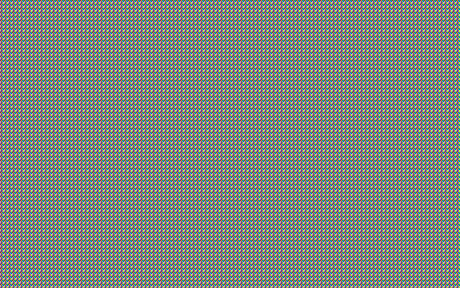

(288, 460) Image

In [15]:
pad = Image(numpy.tile(k.data, (288//4,460//4,1)))
pad

Et voilà! Here's the picture, encrypted by a 384-bit key:

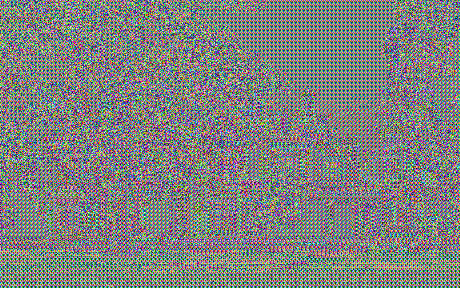

(288, 460) Image

In [16]:
m1 + pad    # pixel values are xor-ed together

<b>To do:</b> Discuss the result. Would you say that this cipher provides message confidentiality against a passive attacker? 

*(double-click on this cell to edit and provide your answer)*

## 2) One-time pad

Go through the same process, this time with a genuine randomly generated one-time pad as large as the image to encrypt.

What's the key-length this time?

Verify that the cipher decrypts correctly, <i>i.e.</i> play both the roles of Alice and Bob to see that everything works as it should. Also make sure to take a look at what Eve actually sees on the insecure channel. Is message confidentiality achieved?

## 3) Stream cipher

The problem with the previous construction is that it is quite inefficient from the point of view of key size: we would like to achieve the same security level using a much smaller key. We will use the ChaCha20 generator provided by the [`randomgen` library](https://pypi.org/project/randomgen/) to generate a key-stream from a 128-bit key. We first aquire 128 bits of fresh random data from the [entropy pool of the system](https://docs.python.org/3/library/os.html#os.urandom). 

In [ ]:
from os import urandom

k = urandom(16)      # 16 bytes of entropy coming from the OS
print(k.hex())

In [ ]:
from numpy import random
from randomgen import ChaCha  # you may need to pip install randomgen

prng = random.Generator(ChaCha(seed=int(k.hex(),16)))

`prng` is now an instance of the ChaCha20 PRNG initialized with seed $k$; you can use to generate successive pixel values as follows.

In [ ]:
[ prng.integers(255) for i in range(10) ]

Note that if you re-initialize the PRNG with the same seed $k$, you get exactly the same values in the same order.

In [ ]:
prng = random.Generator(ChaCha(seed=int(k.hex(),16)))

[ prng.integers(255) for i in range(10) ]

: 

Use this to generate of pseudo-random pad from $k$, and then encrypt the Bletchley Park picture with it. Make sure that Bob is able to decrypt it knowing only $k$. 

### 4) Keystream reuse

A crucial precaution when using stream ciphers is to **never reuse the same keystream twice**. Let's find out what could happen when this recommendation is ignored.

Suppose Alice encrypts both the $m_1$ Bletchley Park picture and the `m2.tiff` file with the exact same keystream derived from a key $k$ using the above encryption scheme. Generate the encrypted images $c_1$ and $c_2$ that would then be sent on the channel.

Now: Eve intercepts $c_1$ and $c_2$. Explain how she may understand what the contents of $m_1$ and $m_2$ are even though she doesn't have access to the encryption key.

### 5) Authenticated encryption

The `cryptography` library in Python provides a high-level, "idiot-proof", general purpose authenticated encryption primitive named `Fernet` (a look at [the documentation](https://cryptography.io/en/latest/fernet/#implementation) show that it's really just AES-128 in CBC mode along with SHA2 digests used for message authentication).

In [ ]:
from cryptography.fernet import Fernet

Having a look again at [the documentation](https://cryptography.io/en/latest/hazmat/primitives/aead/#cryptography.hazmat.primitives.ciphers.aead.AESGCM), go through the whole process:

1) set up a Fernet secret key `k` shared by Alice and Bob (what size?)

2. Alice encrypts the binary data in her image (`m1.tobytes()`) using the Fernet primitive. Make sure to: have a look at the size of the resulting (base64-encoded) ciphertext ("token"), and verify that if the same message is encrypted a second time, a different token is obtained.

3. The token is sent on the channel. Eve looks at the token, learns nothing.

4. Bob receives the token and decrypts it using the secret key. The original image can be recovered using the `Image.frombytes` method (the correct shape of the image needs to be specified since it was lost during encryption).